# Classification: Loan Eligibility Prediction

Welcome to the project on classification of Load Eligibility prediction. We will use the credit risk dataset (**CreditRisk.csv**) for this problem.

----------------
## Context: 
----------------

Credit risk is the risk of loss resulting from the failure by a borrower to repay principal and interest owed to the lender. The lender uses the interest payments from the loan to compensate for the risk of potential losses. When the borrower defaults on their obligations, it can cause an interruption of cash flow for the lender.

In the banking sector this is a very important factor to be considered before approving a loan to an applicant, in order to cushion the lender from any loss of cash flow and to reduce the severity of losses.

------------------
## Objective:
------------------

Easy House is a finance company that deals in several varieties of home loans. They have a presence across urban, semi-urban, and rural areas. Currently, the customer first applies for a home loan post which the company validates the customer's eligibility for that loan. 

Now, the company wants to automate the loan eligibility process. They want to harness their past customers' data to build a model to predict whether the loan should be approved or not. This would help the company prevent potential losses, save time and focus more on eligible customers.

--------------------------
## Data Dictionary:
--------------------------

The data contains the following attributes:

* **Loan_ID**: Unique Loan ID
* **Gender**: Gender of the applicant - Male/Female
* **Married**: Whether the applicant is married or not (Yes/No)
* **Dependents**: Number of dependents of the applicant
* **Education**: Applicant's education (Graduate/Not Graduate)
* **Self_Employed**: Whether the applicant is self-employed (Yes/No)
* **ApplicantIncome**: The income of the applicant (\$)
* **CoapplicantIncome**: The co-applicant's income in case of a joint loan and 0 otherwise (\$)
* **LoanAmount**: Loan amount (dollars in thousands) 
* **Loan_Amount_Term**: Term of loan in months
* **Credit_History**: Whether the applicant's credit history meets required guidelines
* **Property_Area**: The area the property pertaining to the loan belongs to - Urban/Semi-Urban/Rural
* **Loan_Status**: Loan approved (1 - Yes, 0 - No)

## Importing necessary libraries and overview of the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

#### Loading data

In [6]:
# Import library necessary for file uploads
from google.colab import files
# Request the upload of the data file
uploaded = files.upload()

Saving CreditRisk.csv to CreditRisk.csv


In [7]:
data = pd.read_csv("/content/CreditRisk.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360.0,1.0,Urban,1


#### Check the info of the data

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    int64  
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 62.5+ KB


**Observations:**

- There are 614 observations and 13 columns in the data.
- ApplicantIncome, CoapplicantIncome, Loan_Amount_Term, Credit_History, and Loan_Status are numeric data types. The rest of the variables are of the object data type.
- There are several columns with less than 614 non-null entries i.e. these columns have missing values.
- Loan_ID column is an identifier. Let's check if each entry of the column is unique.

In [9]:
data.Loan_ID.nunique()

614

**Observations:**
- We can see that all the entries of this column are unique. Hence, this column would not add any value to our analysis. 
- Let's drop this column.

## Exploratory Data Analysis and Data Preprocessing

#### Dropping Loan_ID column

In [10]:
data.drop(columns=['Loan_ID'], inplace=True)

#### Summary Statistics for numerical columns

In [11]:
# Creating a list of numerical columns
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# Print summary statistics for the list of columns
data[num_cols].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,614.000000,600.00000
mean,5403.459283,1621.245798,141.166124,342.00000
std,6109.041673,2926.248369,88.340630,65.12041
min,150.000000,0.000000,0.000000,12.00000
25%,2877.500000,0.000000,98.000000,360.00000
50%,3812.500000,1188.500000,125.000000,360.00000
75%,5795.000000,2297.250000,164.750000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


**Observations:**
- ApplicantIncome has a right skew with probable outliers, as the max is much higher than the Q3 value.
- CoapplicantIncome seems to have potential outliers to the right, there also seems to be a large number of applications with no CoapplicantIncome.
- LoanAmount has a slight skew, with possible outliers to the right since we see a large jump from the Q3 value to the max value.
- Loan_Amount_Term is heavily lumped at the 360 month mark, since Q1, Median, and Q3 values all sit at 360 months. There also seems to be some outliers to the left, seeing a min loan term at 12 months.

#### Feature Engineering

In [12]:
# Convert the scale of loan term from months to years
data['Loan_Amount_Term']=data['Loan_Amount_Term']/12

In [13]:
# Add the applicant and co-applicant income to get the total income per application
data['total_income']=data['ApplicantIncome'] + data['CoapplicantIncome']

In [14]:
# Drop the columns as we created a new column which captures the same information
data.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)

#### Check the distribution and outliers for each column in the data

LoanAmount
Skew : 2.36


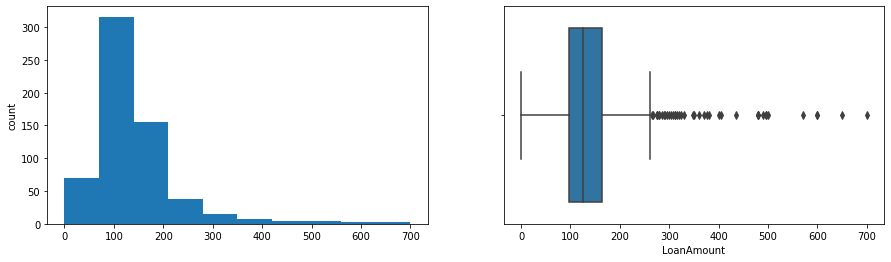

total_income
Skew : 5.63


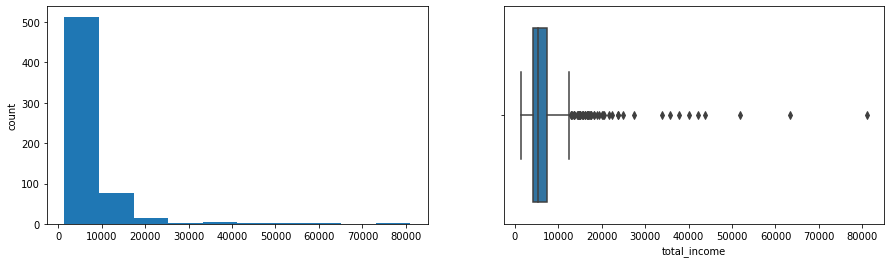

In [15]:
# Print boxplots and histograms for each column in the dataframe
for col in ['LoanAmount', 'total_income']:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observations:**

- Both the variables are highly skewed to the right and have many outliers which can be expected as the data contains different types of areas - Rural, Urban & Semi-Urban. 
- We can observe from the histogram that majority of values for total income are less than 10,000K dollars.

Now, let's check the percentage of observations in each category for all the categorical variables.

#### Checking percentage of each category for categorical variables

In [16]:
# Create a list of categorical columns
cat_col= ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History','Property_Area', 'Loan_Status']

# Print formatted output to display percentages for categorical variables
for col in cat_col:
    print(data[col].value_counts(normalize=True))
    print('*'*40)

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64
****************************************
Yes    0.651391
No     0.348609
Name: Married, dtype: float64
****************************************
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64
****************************************
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
****************************************
No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64
****************************************
1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64
****************************************
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
****************************************
1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64
****************************************


**Observations:**
- 81% of applicants are Male, while roughly 19% are Female.
- Around 65% of applicants are Married.
- Most applicants (around 57%) have no dependents.
- Around 78% of applicants are graduates.
- Around 86% of applicants are self employed.
- Around 16% of applicants do not meet credit requirements.
- There is a relatively even mix of Urban, Semi-urban, and Rural property areas.
- Around 31% of applicants have not yet been approved for a loan.

#### Imputing missing values

In [17]:
# Impute missing values with mode for the categorical variables 
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    data[col].fillna(value=data[col].mode()[0], inplace=True)

In [18]:
# Replace values of 0 with null values in loan amount 
data.LoanAmount.replace(0, np.nan, inplace=True)

# Impute null values in loan amount with the median
data.LoanAmount.fillna(value=data.LoanAmount.median(), inplace=True)

**We are done with the data preprocessing. Let's explore the data a bit more with bivariate analysis.**

Let's check the relationship of loan amount with the total income.

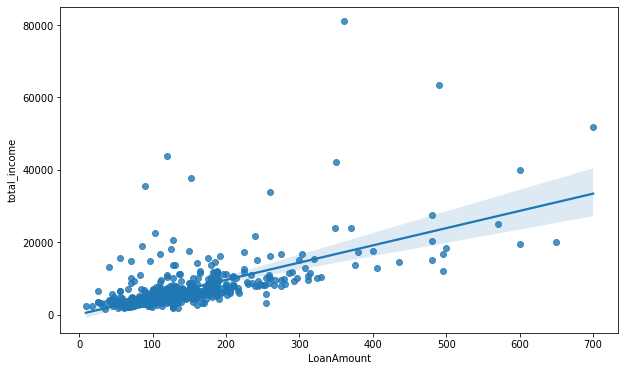

In [19]:
# Print a regression plot for loan amount vs total income
plt.figure(figsize=(10,6))
sns.regplot(x='LoanAmount', y='total_income', data=data)
plt.show()

**Observations:**
- The plot shows that the loan amount is positively correlated with total income. This implies that the loan amount for higher-income applicants is progressively higher.
- There are some outliers visible, showing applicants with low income having been given loans of a higher amount.

Let's check the relationship of total income with loan status

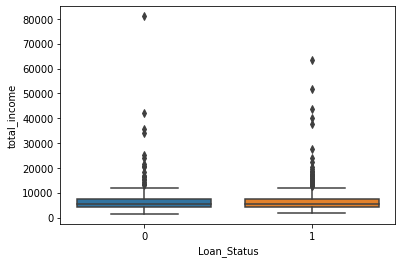

In [20]:
sns.boxplot(x=data.Loan_Status, y=data.total_income)

**Observations:**
- Except for some outliers, there is no major difference between the income of those customers who are eligible versus those who are not. 
- This implies that income alone might not be a good indicator of a customer's loan eligibility.

Let's check how credit history is related to loan status

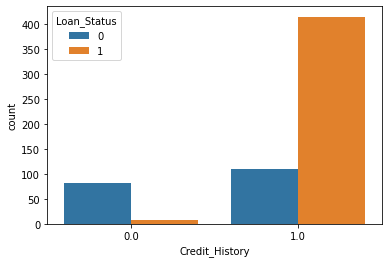

In [21]:
sns.countplot(x=data.Credit_History, hue=data.Loan_Status)

**Observations:**
- The plot shows that credit history is an important factor while checking loan eligibility. There are very few customers whose loan was approved even when their credit history did not meet required guidelines.

Let's check the relationship between education and loan status.

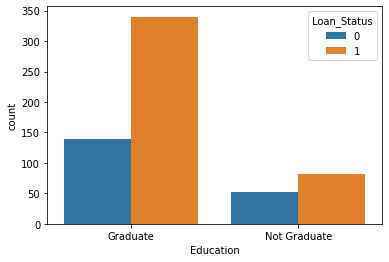

In [22]:
sns.countplot(x=data.Education, hue=data.Loan_Status)

**Observations:**
- We can see that graduate customers are more likely to get loans.
- This might be because, in general, graduate customers have higher income when compared to non-graduates. Let's check if this is true.

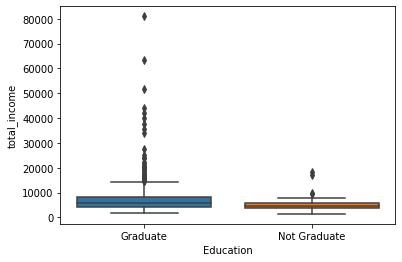

In [23]:
sns.boxplot(x=data.Education, y=data.total_income)

**Observations:**
- We can see that this does appear to be true; graduate customers seem to earn more on average.

Let's check how property area is related with loan status

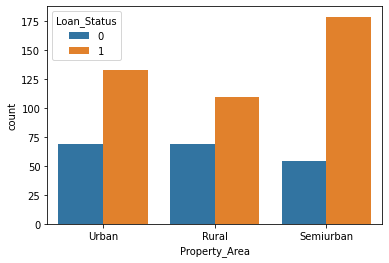

In [24]:
sns.countplot(x=data.Property_Area, hue=data.Loan_Status)

**Observations:**

- The plot shows that more loans are approved for properties in semi-urban areas. 
- This could be due to several reasons. The bank might be charging higher interest rates for semi-urban areas or the current customer base of the company from semi-urban areas might actually be more eligible for home loans based on loan applicant features. We cannot be certain as we don't have the data to support this claim.

**Now that we have processed and explored our data, let's prepare it for modeling.**

## Preparing data for modeling

- Models cannot take non-numeric inputs. So, we will first create dummy variables for all the categorical variables.
- We will then split the data into train and test sets.

We begin by separating the target variable from the other variables.

In [25]:
# Separate target variable and other variables
X = data.drop(columns=['Loan_Status'])
Y = data.Loan_Status

In [26]:
# Create dummy variables, using drop_first=True to avoid redundant variables
X = pd.get_dummies(X, drop_first=True)

In [27]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

## Building Classification Models

**Before training the model, let's choose the appropriate model evaluation criterion as per the problem on hand.**

### Model evaluation criterion:

#### Since this is a binary classification problem, the model can make wrong predictions in one of two ways:
1. Predicting a customer is not eligible for a loan when the customer actually is eligible - Loss of opportunity
2. Predicting a customer is eligible for a loan when the customer is actually not - Financial loss

#### Which case is more important? 
* Predicting that the customer is eligible when he is not, because the person might default or not be able to return the loan, which would result in financial loss to the company.

#### How to reduce this loss i.e need to reduce False Negatives?
* In classification, the class of interest is considered the positive class. Here, the class of interest is 0 i.e. identifying non-eligible customers. So, the company wants to minimize the number of false negatives, in other words **Recall** is the evaluation criterion to be maximized.

Also, let's create a function to calculate and print the classification report and confusion matrix so that we don't have to rewrite the same code repeatedly for each model.

In [28]:
# A function to print the classification report and confusion matrix
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Logistic Regression

We begin by fitting the logistic regression model on the training dataset.

In [30]:
# Initialize the logistic regression model 
log_reg = LogisticRegression(random_state=1)

# Fit the model with the training data
log_reg.fit(X_train, y_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Let's check the coefficient of each dependent variable in the data**

In [32]:
# Obtain the coefficient of each dependent variable
pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False)

Credit_History             3.026215
Property_Area_Semiurban    0.821582
Married_Yes                0.189412
Dependents_2               0.154739
Dependents_3+              0.113786
total_income              -0.000010
LoanAmount                -0.000474
Property_Area_Urban       -0.006442
Loan_Amount_Term          -0.065874
Self_Employed_Yes         -0.098509
Gender_Male               -0.106000
Dependents_1              -0.145727
Education_Not Graduate    -0.491741
dtype: float64

**Observations:**
- Credit History has a very high weight coefficient in this logistic regression model.  As we saw earlier, an applicant's credit history seemed to have a high correlation to whether or not the applicant was eligible for a loan.
- The next largest coefficient is defined for property areas in Semi-urban neighborhoods.  We have also seen a similar correlation between this category and the eligibility of the applicant for a loan.
- Lack of graduate education accounts for a significant negative coefficient in determining eligibility for a loan.

In [33]:
# Determine the odds calculated from the logistic regression model coefficients
odds = np.exp(log_reg.coef_[0])

# Add the odds to a dataframe and sort the values in descending order
pd.DataFrame(odds, X_train.columns, columns=['odds']).sort_values(by='odds', ascending=False) 

,odds
Credit_History,20.619043
Property_Area_Semiurban,2.274095
Married_Yes,1.208539
Dependents_2,1.167353
Dependents_3+,1.120512
total_income,0.999990
LoanAmount,0.999526
Property_Area_Urban,0.993578
Loan_Amount_Term,0.936249
Self_Employed_Yes,0.906187


**Observations:**
- The odds of an applicant obtaining a loan with good credit history is **20.62 times** the odds of an applicant with poor credit history.
- Those applying for loans in Semi-urban areas are **more than twice** as likely to obtain a loan than those in Urban areas.
- Applicants that are married are more **1.2 times** more likely to obtain a loan than those who are not.

**Now, let's check the performance of the model on the training set.** To do this we will use the model to create a prediction using the training data and then using the **metrics_score()** function that we defined earlier, we will run a classification report and display a confusion matrix to evaluate the performance of the prediction.

              precision    recall  f1-score   support

           0       0.91      0.44      0.59       131
           1       0.80      0.98      0.88       298

    accuracy                           0.82       429
   macro avg       0.85      0.71      0.74       429
weighted avg       0.83      0.82      0.79       429



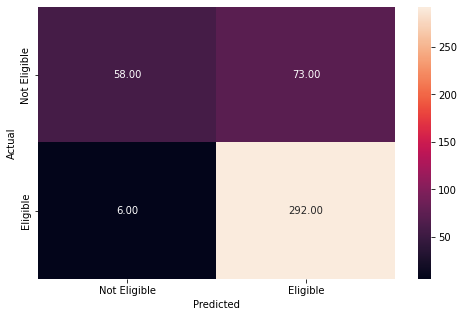

In [34]:
# Use the logistic model to create a prediction on the training data 
y_pred_train = log_reg.predict(X_train)

# Check the performance on the training data
metrics_score(y_train, y_pred_train)


**Reading confusion matrix (clockwise):**

- **True Positive**: Predicting the customer is not eligible and the customer is actually not eligible
- **False Negative**: Predicting the customer is eligible but the customer is actually not eligible
- **True Negative**: Predicting the customer is eligible and the customer is actually eligible
- **False Positive**: Predicting the customer is not eligible but the customer is actually eligible

**Observations:**
- We are getting an accuracy of 82% on the training data.
- However the Recall on class 0 was only 44% on the training data.
- We can see from the confusion matrix that we are picking up a significant number of cases where the model predicts that the applicant is eligible, but is actually not eligible.
- This tells us that our model is not the best at determining when ineligible customers are actually ineligible, which we have already stated is the worst case scenario.

**Precision-Recall Curve for Logistic Regression**

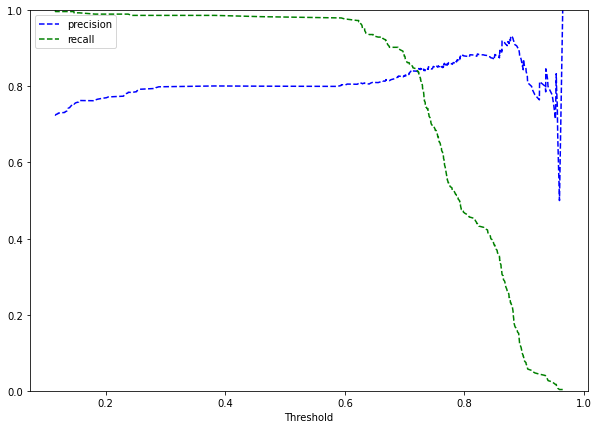

In [35]:
# Determine the probability of each observation belonging to each class
y_scores=log_reg.predict_proba(X_train)

# Obtain information from the precision recall curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

**Observations:**
- We can see that precision and recall are balanced for threshold of about 0.7.
- Let's try to calculate the exact threshold where precision and recall are equal.

In [36]:
# Calculate the exact threshold where precision and recall are equal.
for i in np.arange(len(thresholds)):
    if precisions[i]==recalls[i]:
        print(thresholds[i])

0.7222027953828439


- The threshold of 0.72 would give a balanced precision and recall.
- We can choose the threshold to be a bit higher to make the recall higher but then the precision would drop.
- **This decision depends on the stakeholders and other business driven factors.** For example, if the company can bear the cost of some false positives and be more conservative while approving loans then we can choose for the recall to be higher.
- Let's choose the recall to be 0.75 for the current scenario, since we have mentioned that the company wants to optimize recall.
- **Note:** We also don't want the precision to be so poor that it outweighs the benefits of a higher recall. 

Let's compare the performance of the model on training and testing sets after changing the threshold.

              precision    recall  f1-score   support

           0       0.51      0.73      0.60       131
           1       0.85      0.69      0.76       298

    accuracy                           0.70       429
   macro avg       0.68      0.71      0.68       429
weighted avg       0.75      0.70      0.71       429



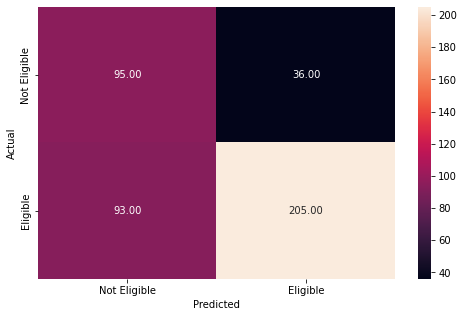

In [37]:
optimal_threshold1 = 0.75
metrics_score(y_train, y_scores[:,1]>optimal_threshold1)

              precision    recall  f1-score   support

           0       0.56      0.66      0.60        61
           1       0.81      0.74      0.78       124

    accuracy                           0.71       185
   macro avg       0.68      0.70      0.69       185
weighted avg       0.73      0.71      0.72       185



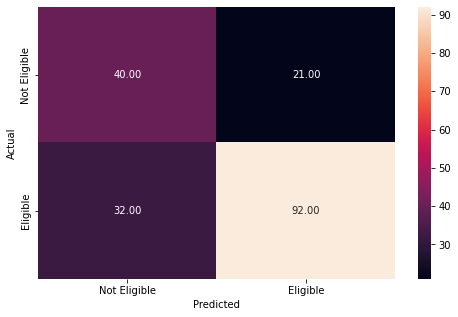

In [38]:
# Check performance on the testing data
y_pred_test = log_reg.predict_proba(X_test)
metrics_score(y_test, y_pred_test[:,1]>optimal_threshold1)

**Observations:**
- After updating the threshold, we see a significant reduction in the number of False Positives. We only mark an applicant as eligible when they should not be **36 times** on the training data and **21 times** on the test data.
- The accuracy of our prediction has dropped to around **70%** in both the test and train data.
- However we see an improved recall in class 0 to **73%** on the train data and **66%** on the test data. However we also see a reduction in precision as well as in the Recall for class 1 on both test and train data.

### K - Nearest Neighbors (KNN)

- KNN is a distance based algorithm and all distance based algorithms are affected by the scale of the data.
- We will scale the attributes (dataframe X defined above) before building the KNN model.

**But before actually building the model, we need to identify the value of K to be used in KNN. We will perform the following steps for the same.**

- For every value of K (from 1 to 20), split the train set into new train and validation set (30 times)
- Scale the training data and validation data
- Take the average of the error on these train and the validation sets for each K
- Plot the average train vs the validation set error for all Ks 
- Choose a suitable K from the plot where the two errors are comparable

In [39]:
knn = KNeighborsClassifier()
ss = StandardScaler()

# We select the best value of k for which the error rate is the least in the validation data
# Let's loop over a few values of the k to determine the best k
train_error = []
test_error = []
knn_many_split = {}

error_df_knn = pd.DataFrame()
features = X.columns

for k in range(1,21):
    train_error = []
    test_error = []
    lista = []
    knn = KNeighborsClassifier(n_neighbors=k)
    for i in range(30):
        x_train_new, x_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size = 0.20)
    
        # Scale the training data with a fit and a transform
        x_train_new = ss.fit_transform(x_train_new)
        # Transform the validation set
        x_val = ss.transform(x_val)
        # Fit knn on the training data
        knn.fit(x_train_new, y_train_new)
        # Calculate the error on the training and validation data
        train_error.append(1 - knn.score(x_train_new, y_train_new)) 
        test_error.append(1 - knn.score(x_val, y_val))
        
    lista.append(sum(train_error)/len(train_error))
    lista.append(sum(test_error)/len(test_error))
    knn_many_split[k] = lista

knn_many_split

{1: [0.0, 0.2693798449612403],
 2: [0.11486880466472305, 0.3387596899224805],
 3: [0.15694849368318753, 0.24263565891472877],
 4: [0.16686103012633619, 0.2713178294573643],
 5: [0.18454810495626825, 0.22325581395348834],
 6: [0.18435374149659864, 0.24457364341085278],
 7: [0.19018464528668608, 0.23100775193798448],
 8: [0.19028182701652094, 0.22403100775193813],
 9: [0.19844509232264337, 0.21472868217054272],
 10: [0.19620991253644318, 0.21860465116279074],
 11: [0.19815354713313899, 0.230232558139535],
 12: [0.1940719144800778, 0.21821705426356594],
 13: [0.2029154518950437, 0.20968992248062016],
 14: [0.19280855199222552, 0.21472868217054264],
 15: [0.19980563654033048, 0.20658914728682173],
 16: [0.1961127308066084, 0.20697674418604656],
 17: [0.2025267249757046, 0.20542635658914735],
 18: [0.19786200194363465, 0.20348837209302323],
 19: [0.20184645286686106, 0.21434108527131784],
 20: [0.19378036929057338, 0.22713178294573638]}

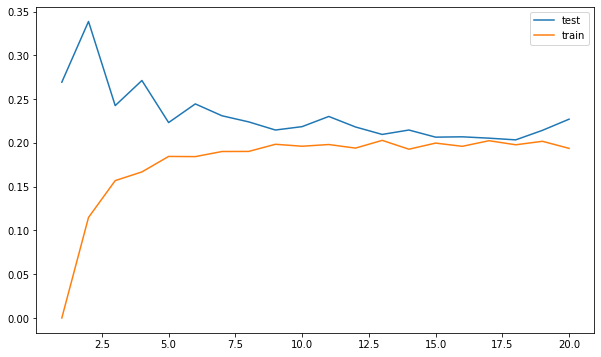

In [40]:
# Extract the training and the testing error for each k into a list for ease of plotting
kltest = []
vltest = []
for k, v in knn_many_split.items():
    kltest.append(k)
    vltest.append(knn_many_split[k][1])

kltrain = []
vltrain = []

for k, v in knn_many_split.items():
    kltrain.append(k)
    vltrain.append(knn_many_split[k][0])

# Plot the value of k vs. the error 
plt.figure(figsize=(10,6))
plt.plot(kltest,vltest, label = 'test' )
plt.plot(kltrain,vltrain, label = 'train')
plt.legend()
plt.show()

**Observations:**
- We can see that the train error and the test error are more or less similar for K more than or equal to 7.
- This implies that we would get generalized results if we choose K=7.
- So, let's scale the full data and fit the model on the entire training set. 

In [41]:
# Scale the data
scaler = StandardScaler()
# Fit and transform the training data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# Transform the testing data
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [42]:
# Fit the model onto the scaled data
knn = KNeighborsClassifier(n_neighbors = 7, weights='distance')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='distance')

**We will now check the performance of the model on the training and testing data.** 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       298

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



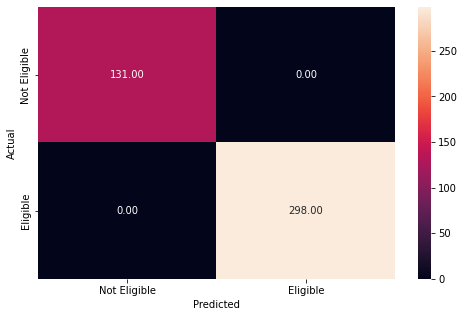

In [43]:
# Predict on training data
y_pred_train_knn = knn.predict(X_train_scaled)

# Check the performance of the model using the metrics_score() function defined earlier
metrics_score(y_train, y_pred_train_knn)

**Observations:**
- It seems this model predicts with **100% accuracy** on the scaled train data, with a recall of **100%** for both classes. This very likely indicates that the model is overfitting.

              precision    recall  f1-score   support

           0       0.61      0.31      0.41        61
           1       0.73      0.90      0.81       124

    accuracy                           0.71       185
   macro avg       0.67      0.61      0.61       185
weighted avg       0.69      0.71      0.68       185



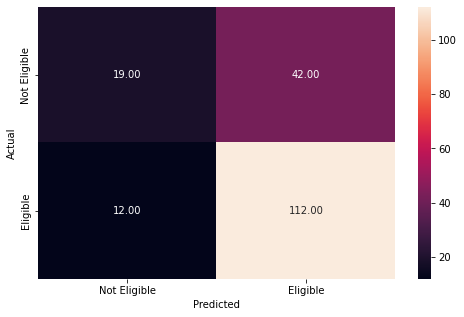

In [44]:
# Predict on the testing data
y_pred_test_knn = knn.predict(X_test_scaled)

# Check the performance of the model
metrics_score(y_test, y_pred_test_knn)

**Observation:**
- When using this model on the test data, we see an accuracy of around **71%**.
- We also see that there is about a **90% chance** that the model will detect that an applicant is eligible when they actually are eligible.
- However, we also see that there is only a **31% chance** that the model will detect that an applicant is not eligible when they are actually not eligible.

## Conclusion:

- We have attempted multiple models and have been able to identify some key factors involved with determining when an applicant is eligible for a loan. 
- After determining a more accurate threshold, we saw increased recall rates in the Logistic Regression model at the expense of minor amounts of accuracy.
- We also see a significant improvement overall on the KNN classifier model on the training data. However, with this model we also see a significant number of False Positives on the testing data.

## Recommendations:

- We see that applicants with high credit scores and those applying in Semi-urban neighborhoods are significantly more likely to be approved for a loan.
- If the organization wishes to minimize credit risk, credit score should be the primary category of focus. Those with high credit are **significantly more likely** to be approved for a loan. 
- It is also worth paying attention to applicants who are Married or have dependents. They are also more likely to be approved.
- Overall we saw the highest Recall and accuracy in the KNN classification model when looking at the training data. Using this model, it can help give a more accurate prediction as to whether or not the applicant should be approved for a loan. It would also be in the company's best interest to verify the results using the criteria mentioned in previous bullet points to double check that the applicant should be approved.